# Velocity Dispersion Comparison with real data

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import ctypes
from colossus.cosmology import cosmology
from scipy import interpolate
from scipy.interpolate import griddata

cosmo = cosmology.setCosmology('planck18')
omega_m = cosmo.Om0
H = cosmo.H0
ibc = ctypes.CDLL("../cmake-build-debug/lib/libfoo.so")

In [2]:
deNicola = pd.read_csv("deNicolaData.csv", sep=',')

In [3]:
deNicola = deNicola[deNicola["stellar_mass"] != "null"]
deNicola

,Name,Morphology,A,Distance_Mpc,Distance_Error_Mpc,Black_Hole_Mass_Msun,Black_Hole_Mass_Error_Msun,velocity_dispersion_kms,velocity_dispersion_error_kms,Luminosity_Lsun,Luminosity_Error_Lsun,Radius_kpc,Radius_error_kpc,B,stellar_mass,Sersic_Index
4,NGC821,S0,1,23.40,1.80,8.22,0.21,2.320,0.020,10.84,0.31,0.33,0.03,1,11,6
5,NGC1023,SB0,2,10.81,0.80,7.62,0.06,2.310,0.020,10.45,0.07,-0.41,0.03,1,10.99,4.2
9,NGC3115,S0/,2,9.54,0.40,8.95,0.10,2.360,0.020,10.93,0.06,0.20,0.06,1,10.93,4.7
12,NGC3377,E5,1,10.99,0.46,8.25,0.25,2.160,0.020,10.64,0.25,0.52,0.02,1,10.5,5.9
16,NGC3608,E1,0,22.80,1.50,8.67,0.10,2.260,0.020,11.04,0.25,0.68,0.03,1,11.03,5.3
23,NGC4459,E2,1,16.01,0.52,7.84,0.09,2.220,0.020,10.64,0.25,0.00,0.01,1,10.98,5.4
24,NGC4473,E5,1,15.25,0.49,7.95,0.24,2.280,0.020,10.80,0.25,0.44,0.01,1,10.96,5
25,NGC4564,S0,2,15.94,0.51,7.95,0.12,2.210,0.020,10.15,0.06,-0.41,0.01,1,10.58,3.2
27,NGC4649,E2,0,16.46,0.61,9.67,0.10,2.580,0.020,11.66,0.06,0.90,0.02,0,11.6,4.6
28,NGC4697,E5,1,12.54,0.40,8.13,0.01,2.250,0.020,11.17,0.31,0.64,0.01,1,11.15,5.3


In [4]:
Aperture = 0.5 # kpc
Beta = 0.1

rows = deNicola.shape[0]
halo_rs = 2000.
halo_c = 10.



In [5]:
def bernardi_k(n, Rre):
    
    bernardi_table = np.array([[7.38, 7.20, 6.80, 6.78, 6.97, 7.30],
                               [6.59, 6.46, 6.23, 6.36, 6.63, 6.97],
                               [5.84, 5.76, 5.69, 5.96, 6.27, 6.62],
                               [5.18, 5.15, 5.21, 5.57, 5.92, 6.27],
                               [4.62, 4.62, 4.79, 5.21, 5.58, 5.93],
                               [4.14, 4.17, 4.42, 4.88, 5.26, 5.60],
                               [3.74, 3.79, 4.09, 4.58, 4.95, 5.29],
                               [3.39, 3.46, 3.79, 4.29, 4.67, 4.99],
                               [3.10, 3.17, 3.52, 4.03, 4.40, 4.71],
                               [2.84, 2.92, 3.28, 3.78, 4.14, 4.44],
                               [2.61, 2.70, 3.06, 3.56, 3.91, 4.19],
                               [2.41, 2.50, 2.86, 3.35, 3.68, 3.95],
                               [2.23, 2.32, 2.68, 3.15, 3.47, 3.73],
                               [2.07, 2.16, 2.51, 2.96, 3.27, 3.52],
                               [1.92, 2.01, 2.36, 2.79, 3.08, 3.32],
                               [1.79, 1.88, 2.21, 2.63, 2.91, 3.13],
                               [1.67, 1.75, 2.08, 2.48, 2.74, 2.95]])
    
    if Rre < 0.1:
        Rre = 0.1

    bernardi_rre_range = np.array([0.1, 0.125, 0.25, 0.5, 0.75, 1])
    bernardi_n_range = np.array([2.00, 2.50, 3.00, 3.50, 4.00, 4.50, 5.00, 5.50, 6.00, 
                                 6.50, 7.00, 7.50, 8.00, 8.50, 9.00, 9.50, 10.00])

    bernardi_x = np.tile(bernardi_rre_range, len(bernardi_n_range)).ravel()
    bernardi_y = np.tile(np.vstack(bernardi_n_range), len(bernardi_rre_range)).ravel()


    bernardi_data = (bernardi_x, bernardi_y)
    sample = (Rre, n)
    grid2 = griddata(bernardi_data, bernardi_table.ravel(), sample, method='cubic')
    
    return grid2

In [6]:
ibc.VD.argtypes =   [ctypes.c_float, 
                     ctypes.c_float,
                     ctypes.c_float, 
                     ctypes.c_float,
                     ctypes.c_float, 
                     ctypes.c_float,
                     ctypes.c_float,
                     ctypes.c_float,
                     ctypes.c_float]

ibc.VD.restype = ctypes.c_float

VD_store = np.array([])
VD_bernardi_store = np.array([])


for index, row in deNicola.iterrows():
    
    radius = 10**row["Radius_kpc"]

    n = float(row["Sersic_Index"])
    sm = 10**float(row["stellar_mass"])
    
    Aperture = 1.5 * 4.84814e-6 * row["Distance_Mpc"] * 10**3
    
    VD = ibc.VD(Aperture, Beta, radius, n, sm, halo_rs, halo_c, omega_m, H)
    VD_store = np.append(VD_store, VD)
    
    VD_bernardi = ((4.3009125e-6*sm)/(bernardi_k(n, Aperture/radius) * radius))**0.5
    
    print(n, Aperture/radius)
    
    VD_bernardi_store = np.append(VD_bernardi_store, VD_bernardi)
    
    print(VD, VD_bernardi)


6.0 0.07959435522059209
261.7303161621094 254.74135623382958
4.2 0.2020654700655773
493.78509521484375 487.8158363867843
4.7 0.043773854118375984
246.51766967773438 241.14640171307332
5.9 0.024135933687586594
120.09069061279297 114.1024752523773
5.3 0.03464186449192836
170.99217224121094 165.324316087688
5.4 0.11642808210000001
347.34881591796875 342.54072898318987
5.0 0.0402657928753651
200.66053771972656 195.13919202798334
3.2 0.29795777917162836
278.98193359375 275.37862105342083
4.6 0.015069409768815423
224.87179565429688 230.58899888701657
5.3 0.02089122699903044
203.687255859375 198.76354540967495
4.9 0.021818477538877525
221.2764892578125 219.27363621362383
2.6 0.17321138109724382
137.00924682617188 133.84772792321579
5.1 0.18021311526754455
858.23193359375 849.1100473124396
3.2 0.07691013332454327
469.864013671875 461.3733737447917


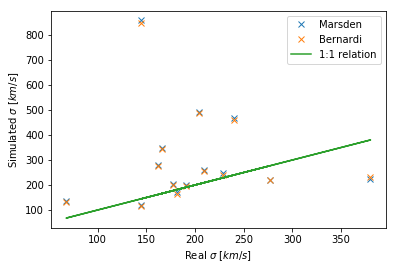

In [7]:
plt.figure()
actual = 10**deNicola["velocity_dispersion_kms"]
plt.plot(actual, VD_store, 'x', label='Marsden')

plt.plot(actual, VD_bernardi_store, 'x', label='Bernardi')

plt.plot(actual, actual, label='1:1 relation')


plt.xlabel("Real $\sigma$ $[km/s]$")
plt.ylabel("Simulated $\sigma$ $[km/s]$")
plt.legend()
plt.show()

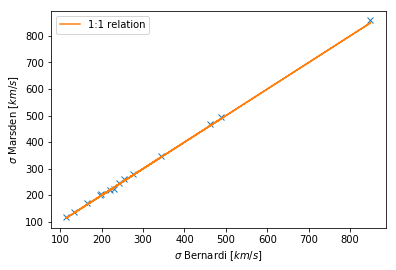

In [8]:
plt.figure()
plt.plot(VD_bernardi_store, VD_store, 'x')
plt.plot(VD_bernardi_store, VD_bernardi_store, label = "1:1 relation")

plt.xlabel("$\sigma$ Bernardi $[km/s]$")
plt.ylabel("$\sigma$ Marsden $[km/s]$")
plt.legend()
plt.show()